# TinyML Autoencoder for ToyADMOS

Start by getting the data into the notebook. We will focus on the first case of toy car example, and use a subset of that dataset to train an autoencoder.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

In [4]:
training_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/NormalSound_IND/"
test_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/AnomalousSound_IND/"

# Get the file paths for the sound files in the training and test path
training_files_path = tf.io.gfile.glob(training_path + "*ch1*.wav")
test_files_path = tf.io.gfile.glob(test_path + "*ch1*.wav")

# Let us reduce the amount of training and test samples for the moment
training_files_path = training_files_path[:50]
test_files_path = test_files_path[:50]

In [5]:
# This is very slow, maybe it could be optimized
training_audio = []
test_audio = []

_, sr = librosa.load(training_files_path[0])

for audio_file in training_files_path:
    sample, _ = librosa.load(audio_file)
    training_audio.append(sample)
    
for audio_file in test_files_path:
    sample, _ = librosa.load(audio_file)
    test_audio.append(sample)
    

Now that we have the audio loaded into memory, we create spectrograms based on the audio.

In [6]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [7]:
def apply_stft(audio_sample):
    stft = librosa.stft(audio_sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    magnitude = np.abs(stft) ** 2
    return librosa.power_to_db(magnitude)

In [8]:
training_magnitudes = []
test_magnitudes = []

for audio in training_audio:
    training_magnitudes.append(apply_stft(audio))
for audio in test_audio:
    test_magnitudes.append(apply_stft(audio))
    
training_magnitudes = np.array(training_magnitudes)
test_magnitudes = np.array(test_magnitudes)

Let us visualize a spectrogram of one of the sound files

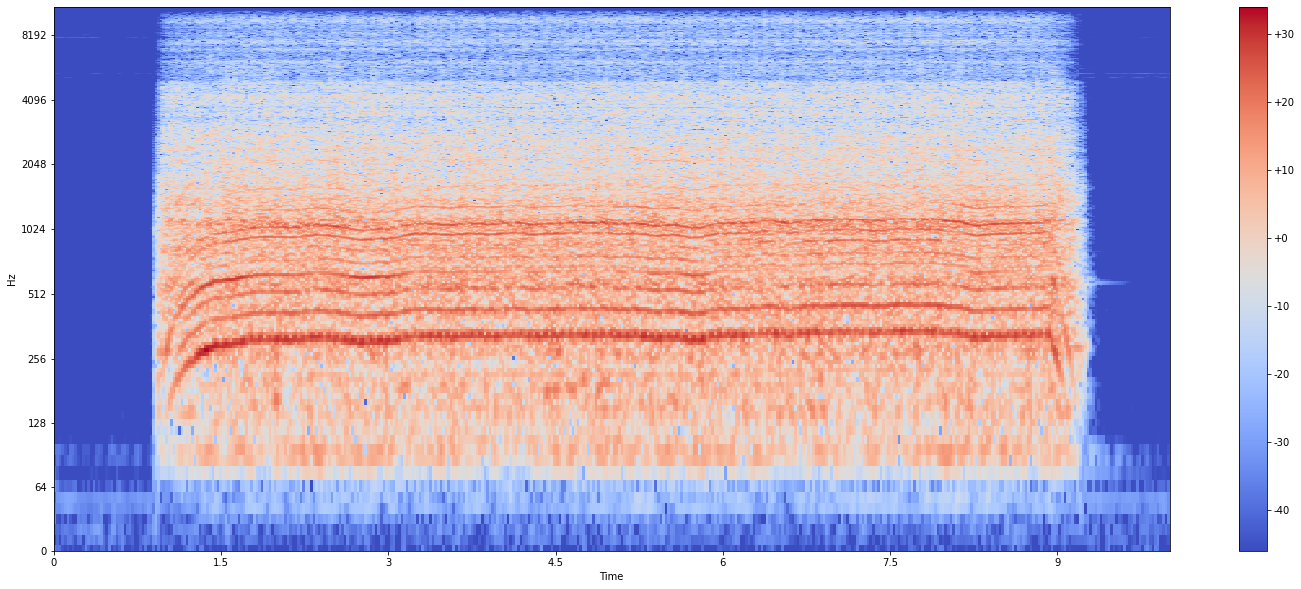

In [9]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[2], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## Defining the model
Having generated the spectrograms we now need to preprocess the them to be suitable for the network. 

In [10]:
training_magnitudes.shape


(50, 1025, 431)

We need to add a new dimension to the datasets to be able to work with tensorflows convolutions that expect dimensions that would normally be present in an image (dataset_dimension, x, y, channels)

In [11]:
training_magnitudes_4D = training_magnitudes[..., tf.newaxis]
test_magnitudes_4D = test_magnitudes[..., tf.newaxis]

# We pad the spectrograms to multiples of 4 to make max pooling and upsampling result in the same shape
x_train = tf.keras.layers.ZeroPadding2D(padding=((3,0),(1,0)))(training_magnitudes_4D)
x_test = tf.keras.layers.ZeroPadding2D(padding=((3,0),(1,0)))(test_magnitudes_4D)

x_train.shape

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-16 11:31:02.103783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-16 11:31:02.104610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorShape([50, 1028, 432, 1])

As it can be seen on the spectrogram plotted above, the current magnitudes range from about +35 to -45. It is problematic that the values include negative numbers as it will not be possible to reconstruct these using the ReLU activation function. Furthermore neural networks work the best in values ranging from 0-1.

Therefore we apply a shift and a scale to keep the magnitudes of the spectrograms inside this range.

In [12]:
# Getting the min and max value to compute the shift and scale
min_value = tf.reduce_min(x_train)
max_value = tf.reduce_max(x_train)

# Apply shift
x_train = tf.math.subtract(x_train, min_value)
x_test = tf.math.subtract(x_test, min_value)

# Apply scale

x_train = x_train / max_value
x_test = x_test / max_value

## Defining the model
We now define an autoencoder to take the preprocessed spectrograms as input.

In [14]:
encoder = tf.keras.models.Sequential()

encoder.add(tf.keras.layers.Conv2D(32, 3, padding="same",
                                   activation="relu", input_shape=x_train.shape[1:]))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1028, 432, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 514, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 514, 216, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 257, 108, 64)     0         
 2D)                                                             
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [15]:
decoder = tf.keras.models.Sequential()

decoder.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(1, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))

decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 257, 108, 32)      18464     
                                                                 
 up_sampling2d (UpSampling2D  (None, 514, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 514, 216, 16)      4624      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 1028, 432, 16)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 1028, 432, 1)      145       
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trai

In [16]:
conv_autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

In [17]:
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [19]:
history = conv_autoencoder.fit(x_train, x_train, batch_size=64, epochs=10)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0841
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0563
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0414
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0482
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0645
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0670
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0517
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0386
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0453
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.0521


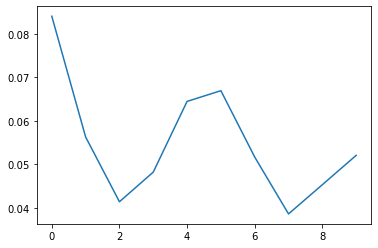

In [20]:
plt.plot(history.history["loss"], label="Training Loss")

In [21]:
reconstructions = conv_autoencoder.predict(x_train)

2022-02-16 11:34:28.144141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [22]:
squeezed_reconstructions = tf.squeeze(reconstructions)
squeezed_reconstructions.shape

TensorShape([50, 1028, 432])

To get back to the original spectrogram scale we shift and scale the reconstructed spectrograms.

In [23]:
scaled_reconstructions = squeezed_reconstructions * max_value

shifted_reconstructions = tf.math.add(scaled_reconstructions, min_value)

### An original spectrogram

In [24]:
# Which spectrogram to visualize
spec_number=8

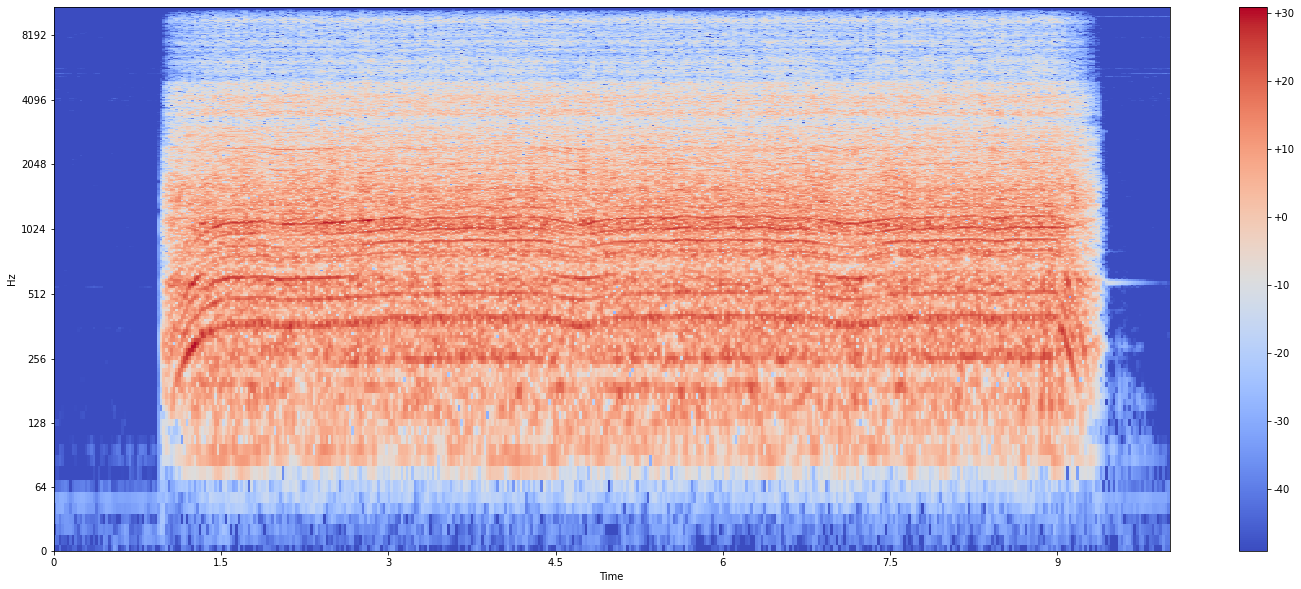

In [25]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[spec_number], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

### The reconstructed image
There seems to be an issue with the autoencoder not generating negative numbers!

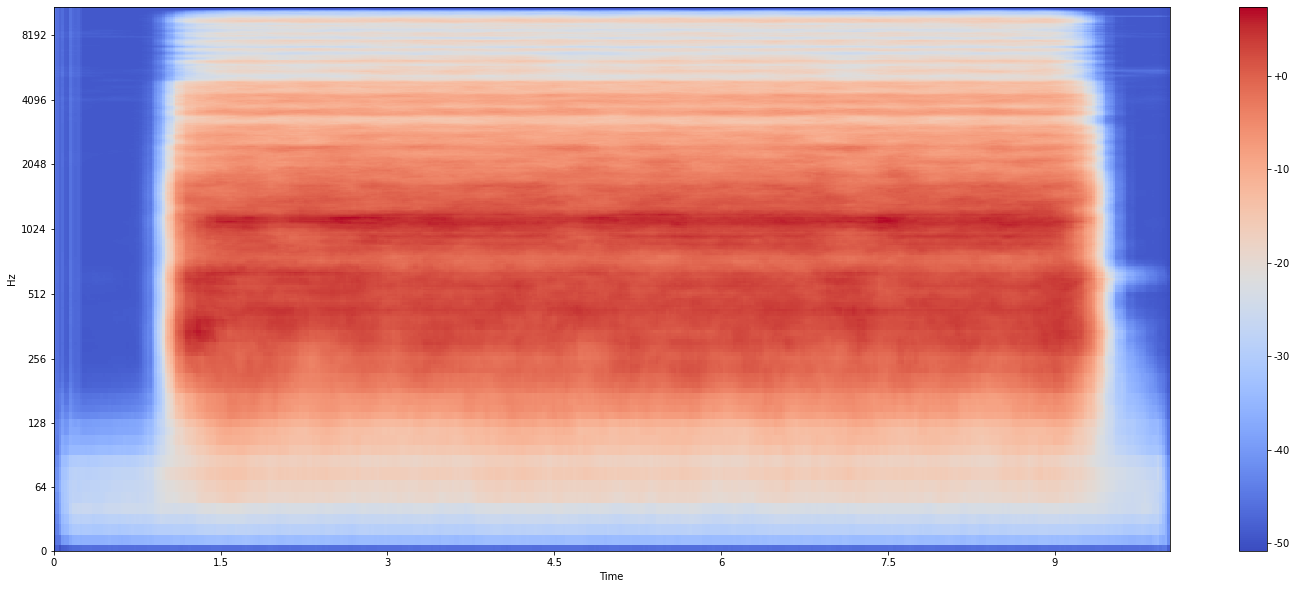

In [26]:
plt.figure(figsize=(25,10))
librosa.display.specshow(shifted_reconstructions[spec_number].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## We now have to define a treshold for when to reject a sample as normal

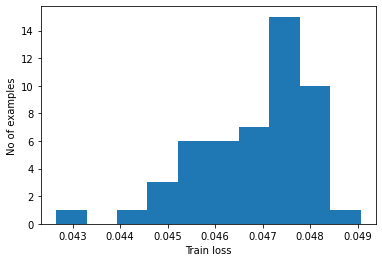

In [27]:
normal_reconstructions = reconstructions

# I implement a for loop to get the mean squared error for every prediction.
# This should also be possible to do with reduction types over a dataset.
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)

normal_losses = []
for i in range(len(x_train)):
    normal_losses.append(mse(normal_reconstructions[i], x_train[i]))

plt.hist(tf.convert_to_tensor(normal_losses)[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

It seems that the loss of normal samples are around 0.028. Lets try to use the test set to see if we see higher reconstruction errors

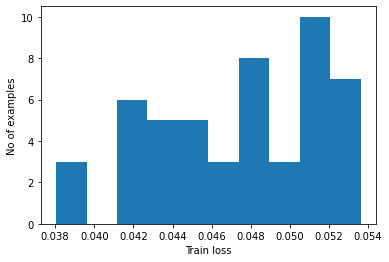

In [28]:
abnormal_reconstructions = conv_autoencoder.predict(x_test)

abnormal_losses = []
for i in range(len(x_test)):
    abnormal_losses.append(mse(abnormal_reconstructions[i], x_test[i]))

plt.hist(tf.convert_to_tensor(abnormal_losses)[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [29]:
np.mean(abnormal_losses)

0.04719736

In [30]:
np.mean(normal_losses)

0.046830054

Currently the model does not seem very useful as the mean loss of the abnormal sounds are less than that of the normal sounds. We still try to define a treshhold that could be used in a better model.

In [36]:
treshold = np.mean(normal_losses) + np.std(normal_losses)
print("Treshold:", treshold)

Treshold: 0.022587497


In [37]:
def predict(model, data, treshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, treshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [38]:
predictions = predict(conv_autoencoder, x_test, treshold)

ResourceExhaustedError: Exception encountered when calling layer "conv2d" (type Conv2D).

OOM when allocating tensor with shape[400,1028,432,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator Simple allocator [Op:Conv2D]

Call arguments received:
  • inputs=tf.Tensor(shape=(400, 1028, 432, 1), dtype=float32)

In [ ]:
print_stats(predictions, tf.zeroes_like(x_test).astype(bool))